## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
from pymystem3 import Mystem
m = Mystem()
from collections import Counter

In [2]:
data = pd.read_csv('/datasets/data.csv')
data.info()
df_ch = data.sort_values('children', ascending = False) # отсортируем данные по количеству детей и сохраним в новой переменной, чтобы не изменять исходные данные 
df_ch.head(10)
for row in df_ch: 
    print(df_ch[row].value_counts())
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64
-327.685916       1
-1197.176853      

**Вывод**

В таблице двенадцать столбцов. Тип данных: 

* float64 - 2 столбца
* int64 - 5 стобцов
* object - 5 столбцов

Согласно документации к данным:

* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

В каждой строке таблицы — данные о заемщике. Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но встречаются проблемы с данными.

* Столбец "children". Ошибочные значения "20", -1. Поменять на 2 и 0 соответственно
* Столбец "gender". Строки с пропущенными данными.
* Столбец "education". Дубликаты в названиях. Привести к одному регистру.
* Столбец "dob_days". Нулевые значения.
* Столбец "purpose". Много дубликатов с похожими или идентичными причинами. Требуется объеденить в одинаковые значения.
* Столбец "days_employed". Положительные и отрицательные значения.
* Столбец "total_income". Пропущенные значения (2174)
* Столбец "days_employed". Пропущенные значения (2174)

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Шаг 2. Предобработка данных

### Обработка пропусков

Пропуски до: 2174
Пропуски до: 2174


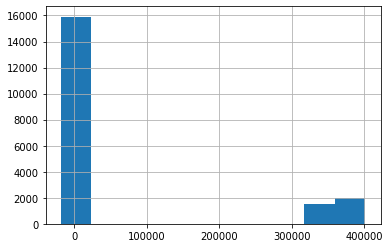

In [3]:
print('Пропуски до:', df_ch['days_employed'].isna().sum())
print('Пропуски до:', df_ch['total_income'].isna().sum())

#отметим пропущенные дни в таблице
df_ch['missing_days_employed'] = df_ch['days_employed'].isna()
df_ch['missing_total_income'] = df_ch['total_income'].isna()

df_ch['days_employed'].hist() # выводим гистограмму, чтобы посмотреть разброс данных в рабочих днях (не показывает отрицательные значения)

# возвращаем по модулю отрицательные рабочие дни
df_ch['days_employed'] = df_ch['days_employed'].apply(abs) 

# возвращаем по модулю отрицательный заработок
df_ch['total_income'] = df_ch['total_income'].apply(abs) 

# перевели из часов в дни
df_ch.loc[data['days_employed'] > 50000, 'days_employed'] = data.loc[data['days_employed'] >300000, 'days_employed'] / 24 

Проблема в данных столбца "days_employed: данные - либо "маленькие и отрицательные", либо "большие и положительные"
Тут, скорее, имело места выгрузка из разных систем, одна из которых считает стаж "наоборот" и в часах. 

По отрицательным данным, вероятен ввод даты вручную. Предположительно, данные отрицательные, потому что перепутали графы "дата начала труд.стажа" и "дата конца труд.стажа".

In [4]:
#(df_ch.loc[df_ch['days_employed'] < 0].median()) # медиана отрицательных значений
#(df_ch.loc[df_ch['days_employed'] > 0].median()) # медиана положительных значений
#(df_ch.loc[df_ch['days_employed'] < 0].median().abs()/df_ch.loc[df_ch['days_employed'] > 0].median()) # соотношение медиан

#смотрим количество пропусков по семейному положению
display(df_ch.groupby('family_status').agg({'missing_days_employed': 'mean',
                                          'missing_total_income': 'mean'}).sort_values(by = 'missing_days_employed', ascending = False))

,missing_days_employed,missing_total_income
family_status,,
гражданский брак,0.105818,0.105818
Не женат / не замужем,0.102382,0.102382
женат / замужем,0.099919,0.099919
вдовец / вдова,0.098958,0.098958
в разводе,0.093724,0.093724


In [5]:
#смотрим количество пропусков по типу занятости
display(df_ch.groupby('income_type').agg({'missing_days_employed': 'mean',
                                         'missing_total_income': 'mean'}).sort_values(by = 'missing_days_employed', ascending = False))

,missing_days_employed,missing_total_income
income_type,,
предприниматель,0.500000,0.500000
пенсионер,0.107106,0.107106
госслужащий,0.100754,0.100754
компаньон,0.099902,0.099902
сотрудник,0.099379,0.099379
безработный,0.000000,0.000000
в декрете,0.000000,0.000000
студент,0.000000,0.000000


Из 21525 значений пропущено 2174. Получается, что стаж и доход не указан примерно для 10% заявителей (безработных, в декрете, студентов и предпринимателей не берем в расчет, их слишком мало). Это значит, что пропуски не зависят от семейного положения и зависят от типа занятости.

Пропуски появились у пенсионеров, госслужащих, компаньонов и сотрудников и зависят от типа занятости. Все это - люди, имеющие постоянный доход. Мое предположение, что эти данные скрыты специально. Вероятно, они скрывают дополнительный доход.

In [6]:
#смотрим медианный доход и медианный стаж по семейному положению
display(df_ch.groupby('family_status').agg({'education': 'count', 
                                            'total_income': 'median',
                                            'days_employed': 'median'}).sort_values(by = 'total_income'))

,education,total_income,days_employed
family_status,,,
вдовец / вдова,960,128213.686950,14053.619941
Не женат / не замужем,2813,144681.423262,1462.009287
гражданский брак,4177,144915.837605,1944.345291
женат / замужем,12380,146184.627236,2304.964439
в разводе,1195,146969.347256,2401.954568


In [7]:
#смотрим медианный доход и медианный стаж по типу занятости
display(df_ch.groupby('income_type').agg({'education': 'count',
                                          'total_income': 'median',
                                          'days_employed': 'median'}).sort_values(by = 'total_income'))

,education,total_income,days_employed
income_type,,,
в декрете,1,53829.130729,3296.759962
студент,1,98201.625314,578.751554
пенсионер,3856,118514.486412,15217.221094
безработный,2,131339.751676,15267.235531
сотрудник,11119,142594.396847,1574.202821
госслужащий,1459,150447.935283,2689.368353
компаньон,5085,172357.950966,1547.382223
предприниматель,2,499163.144947,520.848083


Так же, медианный доход по типу занятости различается довольно значительно. А, вот, например, по семейному положению намного меньше.

In [8]:
#заполним пропуски медианным значением по типу занятости

for income in df_ch['income_type'].unique():
    median_days = df_ch.loc[df_ch['income_type'] == income, 'days_employed'].median()
    median_income = df_ch.loc[df_ch['income_type'] == income,'total_income'].median()
    median_years = df_ch.loc[df_ch['income_type'] == income,'dob_years'].median()
    df_ch.loc[(df_ch['days_employed'].isna()) & (df_ch['income_type'] == income),'days_employed'] = median_days
    df_ch.loc[(df_ch['total_income'].isna()) & (df_ch['income_type'] == income),'total_income'] = median_income
    df_ch.loc[(df_ch['dob_years'] == 0) & (df_ch['income_type'] == income),'total_income'] = median_years                                 

Заполняя пропуски, мы хотим сохранить параметры распределения заполняемой переменной - математическое ожидание и дисперсию. Самый простой способ это сделать - заполнить средним или медианой. В этом случае сохраняется среднее, но дисперсией приходится пожертвовать.

In [9]:
# проверим, что пропуски действительно заполнены

print('Пропуски после:', df_ch['days_employed'].isna().sum())
print('Пропуски после:', df_ch['total_income'].isna().sum())

Пропуски после: 0
Пропуски после: 0


In [10]:
df_ch['children'] = df_ch['children'].replace(20, 2) # убираем 20 детей

20 детей это, очень похоже на опечатку - на клавиатуре 2 и 0 очень близко.

In [11]:
df_ch['children'] = df_ch['children'].replace(-1, 0) # убираем отрицательных детей

-1 это, скорее всего, "нет детей". Вероятно, данные в проекте выгружались из нескольких систем и у одной из них, похоже, такой формат записи.

In [12]:
df_ch[df_ch['gender'] == 'XNA'].count() # узнаем количество пропущенных значений
df_ch = df_ch[df_ch['gender'] != 'XNA'] # удалим строку с пропуском 

Строка с пропуском всего одна, ее удаление не повлияет на дальнейший анализ.

**Вывод**

Во время педобработки данных:

* Отметили пропущенные дни в таблице
* Вывели гистограмму и посмотрели разброс в рабочих днях
* Определили отрицательные значения и причины их появлений 
* Определили количество пропусков и их зависимоть от типа занятости и независимость их от семейного положения
* Заполнили медианными значениями пропуски в рабочих днях и доходе
* Определили появление нулевого значения возраста и заполнили его медианой
* Предположили появление аномальных значений в количестве детей и исправили аномалию
* Определили пропущенное значение в гендере и удалили его за незначительностью выборки

### Замена типа данных

In [13]:
df_ch['days_employed'] = df_ch['days_employed'].astype(int) # обрезаем до полных отработанных дней, заменяя значение float на int
df_ch['total_income'] = df_ch['total_income'].astype(int)
df_ch.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,missing_days_employed,missing_total_income
19562,2,721,30,неоконченное высшее,2,гражданский брак,1,F,компаньон,0,133319,сыграть свадьбу,False,False
11715,2,1034,43,среднее,1,женат / замужем,0,M,сотрудник,0,220771,свой автомобиль,False,False
3302,2,2689,35,среднее,1,Не женат / не замужем,4,F,госслужащий,0,150447,профильное образование,True,True
5315,2,2047,24,среднее,1,женат / замужем,0,F,сотрудник,0,100415,покупка коммерческой недвижимости,False,False
13489,2,16052,62,среднее,1,гражданский брак,1,F,пенсионер,0,192221,операции с коммерческой недвижимостью,False,False
13471,2,630,44,ВЫСШЕЕ,0,женат / замужем,0,M,компаньон,0,245019,дополнительное образование,False,False
15976,2,1574,39,среднее,1,Не женат / не замужем,4,F,сотрудник,0,142594,покупка недвижимости,True,True
8430,2,15217,60,среднее,1,вдовец / вдова,2,F,пенсионер,0,118514,покупка жилья,True,True
14355,2,15771,56,среднее,1,женат / замужем,0,F,пенсионер,0,127947,сделка с подержанным автомобилем,False,False
13256,2,542,46,среднее,1,женат / замужем,0,F,сотрудник,0,84405,операции с недвижимостью,False,False


**Вывод**

6 знаков после запятой в общем трудовом стаже, а так же в доходе за месяц не имеют для данного анализа практической значимости, но на такие данные тяжело смотреть, проще иметь дело с целыми числами.

### Обработка дубликатов

In [14]:
df_ch['education'] = df_ch['education'].str.lower() # убираем прописные буквы в образовании

print(df_ch.duplicated().sum()) # ищем явные дубликаты
df_ch = df_ch.drop_duplicates().reset_index(drop=True) # удаляем их

71


**Вывод**

* Из таблицы удален 71 явный дубликат методом drop_duplicates() с новой индексацией. 
* Методом .str.lower() удалены неявные дубликаты в колонке "образование".

Явные дубликаты могли возникнуть из-за технического сбоя и "задвоиться" в таблице. Неявные дубликаты, вероятнее всего появились из-за склейки нескольких таблиц с названиями столбцов в разном регистре.

### Лемматизация

In [15]:
#создадим функцию которая возвращает строку с ключевыми словами цели кредита
def lemma_pur(purpose):
    lemma = ' ' .join(m.lemmatize(purpose))
    return lemma

df_ch['purpose_word'] = df_ch['purpose'].apply(lemma_pur)

#уникальные значения
df_ch['purpose_word'].unique()

array(['сыграть   свадьба \n', 'свой   автомобиль \n',
       'профильный   образование \n',
       'покупка   коммерческий   недвижимость \n',
       'операция   с   коммерческий   недвижимость \n',
       'дополнительный   образование \n', 'покупка   недвижимость \n',
       'покупка   жилье \n', 'сделка   с   подержанный   автомобиль \n',
       'операция   с   недвижимость \n', 'высокий   образование \n',
       'строительство   собственный   недвижимость \n',
       'на   покупка   подержать   автомобиль \n', 'образование \n',
       'покупка   жилье   для   семья \n', 'операция   с   жилье \n',
       'строительство   жилой   недвижимость \n', 'жилье \n',
       'получение   образование \n',
       'получение   дополнительный   образование \n',
       'на   проведение   свадьба \n', 'автомобиль \n',
       'ремонт   жилье \n', 'операция   со   свой   недвижимость \n',
       'на   покупка   автомобиль \n', 'свадьба \n',
       'покупка   жилье   для   сдача \n', 'недвижимость \n'

**Вывод**

После выделения ключевых слов обнаружены 6 основных категорий:
* автомобиль 
* образование 
* свадьба
* недвижимость 
* строительство 
* жилье 

### Категоризация данных

In [16]:
# Создадим новый столбец (purpose_cat) с категориями на основании результатов лемматизации
def purpose_cat(list):
    if 'автомобиль' in list:
        return "автомобиль"
    if "образование" in list:
        return "образование"
    if "свадьба" in list:
        return "свадьба"
    if "недвижимость" in list:
        return "недвижимость"
    if "строительство" in list:
        return "строительство"
    if "жилье" in list:
        return "жилье"
df_ch['purpose_cat'] = df_ch['purpose_word'].apply(purpose_cat)
df_ch.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,missing_days_employed,missing_total_income,purpose_word,purpose_cat
0,2,721,30,неоконченное высшее,2,гражданский брак,1,F,компаньон,0,133319,сыграть свадьбу,False,False,сыграть свадьба \n,свадьба
1,2,1034,43,среднее,1,женат / замужем,0,M,сотрудник,0,220771,свой автомобиль,False,False,свой автомобиль \n,автомобиль
2,2,2689,35,среднее,1,Не женат / не замужем,4,F,госслужащий,0,150447,профильное образование,True,True,профильный образование \n,образование
3,2,2047,24,среднее,1,женат / замужем,0,F,сотрудник,0,100415,покупка коммерческой недвижимости,False,False,покупка коммерческий недвижимость \n,недвижимость
4,2,16052,62,среднее,1,гражданский брак,1,F,пенсионер,0,192221,операции с коммерческой недвижимостью,False,False,операция с коммерческий недвижимость \n,недвижимость


In [17]:
# Сгрупируем данные о доходе в месяц 

def income_group(row):
    income = row['total_income']
    if income <= 55000:
        return 'Доход 15-55' 
    if income <= 120000 and income > 55000:
        return 'Доход 55-20'    
    if income <= 200000 and income > 120000:
        return 'Доход 120-200'    
    if income <= 4000000 and income > 200000:
        return 'Доход > 200'
df_ch['income_gr'] = df_ch.apply(income_group, axis=1)    
df_ch.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,missing_days_employed,missing_total_income,purpose_word,purpose_cat,income_gr
0,2,721,30,неоконченное высшее,2,гражданский брак,1,F,компаньон,0,133319,сыграть свадьбу,False,False,сыграть свадьба \n,свадьба,Доход 120-200
1,2,1034,43,среднее,1,женат / замужем,0,M,сотрудник,0,220771,свой автомобиль,False,False,свой автомобиль \n,автомобиль,Доход > 200
2,2,2689,35,среднее,1,Не женат / не замужем,4,F,госслужащий,0,150447,профильное образование,True,True,профильный образование \n,образование,Доход 120-200
3,2,2047,24,среднее,1,женат / замужем,0,F,сотрудник,0,100415,покупка коммерческой недвижимости,False,False,покупка коммерческий недвижимость \n,недвижимость,Доход 55-20
4,2,16052,62,среднее,1,гражданский брак,1,F,пенсионер,0,192221,операции с коммерческой недвижимостью,False,False,операция с коммерческий недвижимость \n,недвижимость,Доход 120-200


In [18]:
# Сгруппируем данные по колчеству детей
def children_group(row):
    child = row['children']
    if child == 0:
        return 'нет детей' 
    if child == 1:
        return '1 ребенок'    
    if child == 2:
        return '2 ребенка'    
    if child >= 3:
        return 'многодетные'
df_ch['children_gr'] = df_ch.apply(children_group, axis=1)
df_ch.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,missing_days_employed,missing_total_income,purpose_word,purpose_cat,income_gr,children_gr
0,2,721,30,неоконченное высшее,2,гражданский брак,1,F,компаньон,0,133319,сыграть свадьбу,False,False,сыграть свадьба \n,свадьба,Доход 120-200,2 ребенка
1,2,1034,43,среднее,1,женат / замужем,0,M,сотрудник,0,220771,свой автомобиль,False,False,свой автомобиль \n,автомобиль,Доход > 200,2 ребенка
2,2,2689,35,среднее,1,Не женат / не замужем,4,F,госслужащий,0,150447,профильное образование,True,True,профильный образование \n,образование,Доход 120-200,2 ребенка
3,2,2047,24,среднее,1,женат / замужем,0,F,сотрудник,0,100415,покупка коммерческой недвижимости,False,False,покупка коммерческий недвижимость \n,недвижимость,Доход 55-20,2 ребенка
4,2,16052,62,среднее,1,гражданский брак,1,F,пенсионер,0,192221,операции с коммерческой недвижимостью,False,False,операция с коммерческий недвижимость \n,недвижимость,Доход 120-200,2 ребенка


**Вывод**

После группировки цели кредита разделены на 6 категорий.

После группировки доход разделен на 4 категории.

После группировки количество детей разделено на 4 категории.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [19]:
late_payment = df_ch[(df_ch['debt'] == 1)].count() / df_ch[(df_ch['debt'] == 0)].count()
print(late_payment['debt'])

children_pivot = df_ch.pivot_table(index=['debt'], columns='children_gr', values = 'family_status_id', aggfunc='count')
ch0 = children_pivot['нет детей'][1] / children_pivot['нет детей'][0]
ch1 = children_pivot['1 ребенок'][1] / children_pivot['1 ребенок'][0]
ch2 = children_pivot['2 ребенка'][1] / children_pivot['2 ребенка'][0]
ch3 = children_pivot['многодетные'][1] / children_pivot['многодетные'][0]


display(children_pivot)
print("{0:.2f}% нет детей".format(ch0*100))
print("{0:.2f}% 1 ребенок".format(ch1*100))
print("{0:.2f}% 2 ребенка".format(ch2*100))
print("{0:.2f}% многодетные".format(ch3*100))

0.08832183441558442


children_gr,1 ребенок,2 ребенка,многодетные,нет детей
debt,,,,
0,4364,1926,349,13073
1,444,202,31,1064


8.14% нет детей
10.17% 1 ребенок
10.49% 2 ребенка
8.88% многодетные


**Вывод**

Без дополнительных параметров в 8,8% случаем кредит не выплачивается вовремя. Посмотрим как меняется это значение в зависимости от других факторов.

В среднем с появлением ребенка увеличивает возможность просрочки платежа по кредиту. Многодетные задерживают платежи меньше, чем семьи с одним или двумя детьми, но чаще, чем бездетные.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [20]:
marry_pivot = df_ch.pivot_table(index=['debt'], columns='family_status', values='total_income', aggfunc='count')
no_family = marry_pivot['Не женат / не замужем'][1] / marry_pivot['Не женат / не замужем'][0]
divorce = marry_pivot['в разводе'][1] / marry_pivot['в разводе'][0]
widow = marry_pivot['вдовец / вдова'][1] / marry_pivot['вдовец / вдова'][0]
partner = marry_pivot['гражданский брак'][1] / marry_pivot['гражданский брак'][0]
family = marry_pivot['женат / замужем'][1] / marry_pivot['женат / замужем'][0]


print("{0:.2f}% Не женат / не замужем".format(no_family*100))
print("{0:.2f}% в разводе".format(divorce*100))
print("{0:.2f}% вдовец / вдова".format(widow*100))
print("{0:.2f}% гражданский брак".format(partner*100))
print("{0:.2f}% женат / замужем".format(family*100))
marry_pivot

10.80% Не женат / не замужем
7.66% в разводе
7.03% вдовец / вдова
10.31% гражданский брак
8.16% женат / замужем


family_status,Не женат / не замужем,в разводе,вдовец / вдова,гражданский брак,женат / замужем
debt,,,,,
0,2536,1110,896,3762,11408
1,274,85,63,388,931


**Вывод**

Не женатые/ Не замужние или люди в гражданском браке реже выплачивают кредит в срок.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [21]:
cash_pivot = df_ch.pivot_table(index = 'income_gr', columns = 'debt', values = 'total_income', aggfunc = 'count')
cash_pivot.columns = ['no_debt', 'debt',] 
cash_pivot['%'] = cash_pivot['debt'] / (cash_pivot['debt'] + cash_pivot['no_debt'])
cash_pivot.sort_values(by='%', ascending = False)

,no_debt,debt,%
income_gr,,,
Доход 120-200,8328,793,0.086942
Доход 55-20,6067,548,0.082842
Доход > 200,4683,357,0.070833
Доход 15-55,634,43,0.063516


**Вывод**

Парадоксально люди с наименьшим доходом чаще других групп выплачивают кредит в срок.

- Как разные цели кредита влияют на его возврат в срок?

In [22]:
purpose_pivot = df_ch.pivot_table(index=['debt'], columns='purpose_cat', values='income_type', aggfunc='count')
display(purpose_pivot)

in1 = purpose_pivot['автомобиль'][1] / purpose_pivot['автомобиль'][0]
in2 = purpose_pivot['жилье'][1] / purpose_pivot['жилье'][0]
in3 = purpose_pivot['недвижимость'][1] / purpose_pivot['недвижимость'][0]
in4 = purpose_pivot['образование'][1] / purpose_pivot['образование'][0]
in5 = purpose_pivot['свадьба'][1] / purpose_pivot['свадьба'][0]

print("{0:.2f}% автомобиль".format(in1*100))
print("{0:.2f}% жилье".format(in2*100))
print("{0:.2f}% недвижимость".format(in3*100))
print("{0:.2f}% образование".format(in4*100))
print("{0:.2f}% свадьба".format(in5*100))

purpose_cat,автомобиль,жилье,недвижимость,образование,свадьба
debt,,,,,
0,3903,4152,5876,3643,2138
1,403,308,474,370,186


10.33% автомобиль
7.42% жилье
8.07% недвижимость
10.16% образование
8.70% свадьба


**Вывод**

Люди с большей вероятностью выплачивают кредит если он взят на жилье, недвижимость или свадьбу.

## Шаг 4. Общий вывод

Во время педобработки данных:

* **Отработаны пропуски в данных, заполнены медианными значениями и предположены причины их появления**

Из 21525 значений пропущено 2174. Получается, что стаж и доход не указан примерно для 10% заявителей (безработных, в декрете, студентов и предпринимателей не берем в расчет, их слишком мало). Это значит, что пропуски не зависят от семейного положения и зависят от типа занятости.

Пропуски появились у пенсионеров, госслужащих, компаньонов и сотрудников и зависят от типа занятости. Все это - люди, имеющие постоянный доход. Мое предположение, что эти данные скрыты специально. Вероятно, они скрывают дополнительный доход.

Так же, медианный доход по типу занятости различается довольно значительно. А, вот, например, по семейному положению намного меньше.

Заполняя пропуски, мы хотим сохранить параметры распределения заполняемой переменной - математическое ожидание и дисперсию. Самый простой способ это сделать - заполнить средним или медианой. В этом случае сохраняется среднее, но дисперсией приходится пожертвовать.

* **Определены дубликаты, удалены явные, исправлены неявные и предположены причины их появлений**

Явные дубликаты могли возникнуть из-за технического сбоя и "задвоиться" в таблице. Неявные дубликаты, вероятнее всего появились из-за склейки нескольких таблиц с названиями столбцов в разном регистре.

* **Выделены категории для целей кредита, а так же группы по доходу и количеству детей** 

Цели кредита разделены на 6 категорий.
Доход разделен на 4 категории.
Количество детей разделено на 4 категории.

* **При помощи сводных таблиц, проведена, какие критерии влияют на возврат кредита**

Без дополнительных параметров в 8,8% случаем кредит не выплачивается вовремя. Посмотрим как меняется это значение в зависимости от других факторов. В среднем с появлением ребенка увеличивает возможность просрочки платежа по кредиту. Многодетные задерживают платежи, в 8,8%, как если бы дети вообще не имели влияния на выплаты.

Не женатые/ Не замужние или люди в гражданском браке реже выплачивают кредит в срок.

Люди с большей вероятностью выплачивают кредит если он взят на жилье, недвижимость или свадьбу.


Дополнительный анализ может помочь более точно предсказать вероятность вылпаты кредита в срок.
